In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from scipy import stats
import pickle
from functools import reduce
import glob
import os
import h5py
import tqdm
import plotly.express as px
pd.set_option('display.float_format', lambda x: '%.6f' % x)


def load_pickle(file_path):
    with open(file_path, 'rb') as f:
        data = pickle.load(f)
    return data


def load_h5(file_path):
    with h5py.File(file_path, 'r') as f:
        return load_group(f)


def load_group(group):
    out = {}
    for key in group.keys():
        # 如果 key 不是 str 类型，将其转换为字符串
        key_str = key if isinstance(key, str) else '_'.join(map(str, key))
        item = group[key]
        # 如果是一个数据集，则直接读取数据；如果是 group，则递归读取
        if isinstance(item, h5py.Dataset):
            out[key_str] = item[()]
        elif isinstance(item, h5py.Group):
            out[key_str] = load_group(item)
        else:
            out[key_str] = None
    return out


def get_price_h5():
    price_h5 = load_h5('data/price.h5')
    price_data = price_h5['price']
    # 将 axis0 中的 bytes 转换成字符串
    index = pd.to_datetime(price_data['axis1'])
    # axis1 数组可以作为列名，如果需要进一步转换（例如时间戳转换为日期），可以按需处理
    columns = [item.decode('utf-8') if isinstance(item, bytes) else item for item in price_data['axis0']]
    # block0_values 是数据的二维数组
    values = price_data['block0_values']
    # 构造 DataFrame
    daily_close_df = pd.DataFrame(values, index=index, columns=columns)
    return daily_close_df


def wide_to_long(df, value_name):
    long_df = df.melt(id_vars="date", var_name="stock", value_name=value_name)
    return long_df

c:\Users\26954\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
c:\Users\26954\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


### 1.数据处理

#### 1.1 读取

In [ ]:
# 每月最后一个交易日日期列表
daily_zz500_df = load_pickle('data/zz500.pk').reset_index()
last_trading_days = daily_zz500_df.groupby(daily_zz500_df['date'].dt.to_period('M'))['date'].max().sort_values()
last_trading_day_list = last_trading_days.tolist()

csi500_mask_monthly_df = load_pickle('data/csi500_mask_monthly.pkl').reset_index()
monthly_returns_df = load_pickle('data/monthly_returns.pkl').reset_index()

blacklist_df = load_pickle('data/BLACKLIST.pkl').reset_index()
blacklist_df.rename({'asset':'stock'},axis=1,inplace=True)
blacklist_df['blacklist'] = True
monthly_blacklist = blacklist_df[blacklist_df['date'].isin(last_trading_day_list)]
monthly_blacklist['date'] = monthly_blacklist['date'].dt.to_period('M').dt.to_timestamp('M')
dates = pd.date_range(start='2007-01-01', end='2024-06-30', freq='M')
monthly_blacklist = monthly_blacklist[monthly_blacklist['date'].isin(dates)].reset_index(drop=True)

untradable_df = load_pickle('data/UNTRADABLE.pkl').reset_index()
untradable_df.rename({'asset':'stock'},axis=1,inplace=True)
untradable_df['untradable'] = True
monthly_untradable = untradable_df[untradable_df['date'].isin(last_trading_day_list)]
monthly_untradable['date'] = monthly_untradable['date'].dt.to_period('M').dt.to_timestamp('M')
dates = pd.date_range(start='2007-01-01', end='2024-06-30', freq='M')
monthly_untradable = monthly_untradable[monthly_untradable['date'].isin(dates)].reset_index(drop=True)

# 市值(单位元) 月频
mcap_df = load_pickle('data/mcap.pkl').reset_index()
# 成交额(单位元)
daily_amount_df = load_pickle('data/daily_amount.pkl').reset_index()
# 成交量(单位股)
daily_volume_df = load_pickle('data/daily_volume.pkl').reset_index()
# 换手率
daily_turnover_df = load_pickle('data/daily_turnover.pkl').reset_index()


daily_close_df = get_price_h5()
daily_close_df = daily_close_df.reset_index().rename(columns={"index": "date"})

ff5_df = pd.read_csv('data/FF5.csv')
HXZ_df = pd.read_csv('data/HXZ.csv')
ff5_df['date'] = pd.to_datetime(ff5_df['date'])
HXZ_df['date'] = pd.to_datetime(HXZ_df['date'])

# 处理成交额数据，取每月最后一天的成交额
daily_amount_df['order_book_id'] = daily_amount_df['order_book_id'].str.replace('.XSHE', '.SZ', regex=False)
daily_amount_df['order_book_id'] = daily_amount_df['order_book_id'].str.replace('.XSHG', '.SH', regex=False)
# 2. 确保 date 列为 datetime 类型，并按股票、日期排序
daily_amount_df['date'] = pd.to_datetime(daily_amount_df['date'])
daily_amount_df.sort_values(by=['order_book_id', 'date'], inplace=True)
# 3. 按 order_book_id 与每个月分组，提取每组最后一天的记录
monthly_turnover = daily_amount_df.groupby(
    ['order_book_id', pd.Grouper(key='date', freq='M')]
).last().reset_index()
# 4. 将 date 列统一转换为当月末的日期
monthly_turnover['date'] = monthly_turnover['date'].dt.to_period('M').dt.to_timestamp('M')
# 5. 根据预定义日期范围筛选
dates = pd.date_range(start='2007-01-01', end='2024-06-30', freq='M')
monthly_turnover = monthly_turnover[monthly_turnover['date'].isin(dates)].reset_index(drop=True)
monthly_turnover.rename({'order_book_id':'stock'},axis=1,inplace=True)

C:\Users\sting0310\AppData\Local\Temp\ipykernel_31224\653185667.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  monthly_blacklist['date'] = monthly_blacklist['date'].dt.to_period('M').dt.to_timestamp('M')
C:\Users\sting0310\AppData\Local\Temp\ipykernel_31224\653185667.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  monthly_untradable['date'] = monthly_untradable['date'].dt.to_period('M').dt.to_timestamp('M')


#### 1.2 拼接

In [ ]:
# 定义训练集，验证集和测试集的时间区间
train_start = pd.to_datetime('2007-02-01')
train_end = pd.to_datetime('2014-01-31')
valid_start = pd.to_datetime('2014-02-01')
valid_end = pd.to_datetime('2016-12-31')
test_start = pd.to_datetime('2017-01-01')
test_end = pd.to_datetime('2024-05-31')

# 处理基础数据--保留中证500的成分股、可交易、未在黑名单中
dataset = monthly_returns_df[(monthly_returns_df['date'] >= train_start)].copy()
returns_long = wide_to_long(dataset, "monthly_return")
returns_long['monthly_return'] = returns_long.groupby("stock")['monthly_return'].shift(-1)  # 收益滞后一期
mask_long = wide_to_long(csi500_mask_monthly_df, "in_csi500")
mcap_long = wide_to_long(mcap_df, "mcap")
dfs_to_merge = [returns_long, mask_long, monthly_untradable, monthly_blacklist, mcap_long, monthly_turnover]
merged_df = reduce(lambda left, right: pd.merge(left, right, on=["date", "stock"], how="left"), dfs_to_merge)
result_df = merged_df[
    (merged_df["in_csi500"] == True) & (merged_df["untradable"].isnull()) & (merged_df["blacklist"].isnull())].copy()
result_df.sort_values(by='date', inplace=True)
result_df.reset_index(drop=True, inplace=True)
result_df = result_df[['date', 'stock', 'monthly_return', 'mcap', 'total_turnover']]
result_df['mcap'] = result_df['mcap'] / 1e8
result_df['total_turnover'] = result_df['total_turnover'] / 1e8

# 拼接ff5和HXZ
dfs_to_merge = [result_df, ff5_df, HXZ_df.drop('MKT', axis=1)]
merged_df1 = reduce(lambda left, right: pd.merge(left, right, on=["date"], how="left"), dfs_to_merge)
merged_df1 = merged_df1[merged_df1['date']<=test_end]

# 拼接features500
folder_path = 'data/features500'
pkl_files = glob.glob(os.path.join(folder_path, '*.pkl'))

for file_path in tqdm.tqdm(pkl_files):
    # 1. 读取 pkl 文件为 DataFrame
    df_feature = load_pickle(file_path).reset_index()

    # 2. 将宽表转换为窄表（melt 操作），这里假设宽表中 "date" 列存在
    df_feature_long = wide_to_long(df_feature, value_name='value')

    # 3. 为便于区分不同特征，将当前文件的特征名从文件名中提取出来，
    # 并将窄表中的 "value" 列重命名为该特征名
    feature_name = os.path.splitext(os.path.basename(file_path))[0]
    df_feature_long.rename(columns={'value': feature_name}, inplace=True)

    # 4. 合并到 merged_df1 上（使用 left join，公共键为 'date' 和 'stock'）
    merged_df1 = pd.merge(merged_df1, df_feature_long, on=['date', 'stock'], how='left')

# 储存为parquet
# merged_df1.to_parquet('datasets.parquet', engine='pyarrow', index=False)

100%|██████████| 218/218 [01:47<00:00,  2.02it/s]


In [ ]:
merged_df1

date      stock  monthly_return       mcap  total_turnover  \
0     2007-02-28  600966.SH        0.067916  23.980320        0.912423   
1     2007-02-28  600530.SH        0.083004  18.216000        0.380347   
2     2007-02-28  600365.SH        0.113661  12.810000        0.343150   
3     2007-02-28  600726.SH        0.181609  58.317716        1.722913   
4     2007-02-28  600969.SH        0.112628  12.321688        0.630311   
...          ...        ...             ...        ...             ...   
99451 2024-05-31  300502.SZ        0.216995 615.712771       18.776626   
99452 2024-05-31  600704.SH       -0.095833 249.281378        1.259818   
99453 2024-05-31  300073.SZ       -0.117998 200.979507        4.861991   
99454 2024-05-31  002517.SZ       -0.114000 234.193919        2.957252   
99455 2024-05-31  002506.SZ       -0.133929 131.047088        0.952916   

            MKT       SMB      HML       RMW      CMA  ...   tpi_21  \
0      0.081900  0.214277 0.222927 -0.226400 0.160120  ... 0.004469   
1      0.081900  0.214277 0.222927 -0.226400 0.160120  ... 0.005365   
2      0.081900  0.214277 0.222927 -0.226400 0.160120  ... 0.008228   
3      0.081900  0.214277 0.222927 -0.226400 0.160120  ... 0.005178   
4      0.081900  0.214277 0.222927 -0.226400 0.160120  ... 0.003568   
...         ...       ...      ...       ...      ...  ...      ...   
99451 -0.008524 -0.003845 0.058808  0.020994 0.001726  ... 0.003092   
99452 -0.008524 -0.003845 0.058808  0.020994 0.001726  ... 0.006601   
99453 -0.008524 -0.003845 0.058808  0.020994 0.001726  ... 0.004369   
99454 -0.008524 -0.003845 0.058808  0.020994 0.001726  ... 0.007037   
99455 -0.008524 -0.003845 0.058808  0.020994 0.001726  ... 0.010345   

       turnover_252  two_year_capital_exp_yoy_pct_chg  value_at_risk_252  \
0          4.456700                         -0.648929          -0.035496   
1          2.918474                          3.441509          -0.046069   
2          4.374421                         -0.920838          -0.057746   
3          3.523176                         -0.023951          -0.042135   
4          3.993007                         -0.815486          -0.043525   
...             ...                               ...                ...   
99451      8.337374                          1.866242          -0.062150   
99452      1.120710                         -0.320256          -0.019115   
99453      3.222210                          1.410800          -0.042500   
99454      3.515734                          0.762787          -0.057907   
99455      1.109455                          0.479601          -0.023605   

       west_eps_fy1  west_eps_fy1_chg_1m  west_netprofit_fy1_1m  \
0               NaN             0.076300              13.855055   
1               NaN             0.000000               0.000000   
2               NaN             0.000000               0.000000   
3               NaN             0.000000               0.000000   
4               NaN             0.000000               0.000000   
...             ...                  ...                    ...   
99451      2.073800                  NaN                    NaN   
99452      0.793400                  NaN                    NaN   
99453      2.245000                  NaN                    NaN   
99454      0.860500                  NaN                    NaN   
99455      0.048400                  NaN                    NaN   

       west_stdeps_fy1  working_capital_to_asset  zero_return_ratio_252  
0             0.078500                  0.207070               0.028340  
1             0.000000                  0.371960               0.041152  
2             0.000000                  0.453077               0.004237  
3             0.000000                  0.069150               0.052885  
4             0.000000                  0.131685               0.054054  
...                ...                       ...                    ...  
99451              NaN            

### 2.预处理

In [2]:
# 定义训练集，验证集和测试集的时间区间
train_start = pd.to_datetime('2007-02-01')
train_end = pd.to_datetime('2014-01-31')
valid_start = pd.to_datetime('2014-02-01')
valid_end = pd.to_datetime('2016-12-31')
test_start = pd.to_datetime('2017-01-01')
test_end = pd.to_datetime('2024-05-31')

# 读取数据，划分
df = pd.read_parquet('datasets.parquet', engine='pyarrow')
train_df = df[(df['date'] >= train_start) & (df['date'] < train_end)].copy()
valid_df = df[df['date'].between(valid_start,valid_end)].copy()
test_df = df[df['date'].between(test_start,test_end)].copy()

# zz500月度收益数据
import akshare as ak
index_zh_a_hist_df = ak.index_zh_a_hist(symbol="000905", period="monthly", start_date="19700101", end_date="22220101")
index_zh_a_hist_df.rename({'日期':'date','涨跌幅':'zz500_return'},axis=1,inplace=True)
index_zh_a_hist_df['date'] = pd.to_datetime(index_zh_a_hist_df['date'])
index_zh_a_hist_df['date'] = index_zh_a_hist_df['date'] + pd.offsets.MonthEnd(0)
index_zh_a_hist_df['zz500_return'] = index_zh_a_hist_df['zz500_return']*0.01

#### 2.1 缺失值
排除训练集中缺失率在30%以上的因子，缺失率在5%~30%的大部分为基本面因子，因此选择不填充，即后续在多空组合中自动过滤掉空值股票

In [3]:
# 用chatgpt对因子进行分类
def categorize_factor(factor):
    f_lower = factor.lower()

    # 先判断一些特定的因子（比如Fama-French因子）
    if factor in ['MKT', 'SMB', 'HML', 'RMW', 'CMA']:
        return 'Fama-French / 因子投资'

    # 分类规则，根据名称中包含的关键词
    if any(k in f_lower for k in ['mcap', 'size', 'total_mv']):
        return '规模'
    if 'turnover' in f_lower:
        return '流动性'
    if 'momentum' in f_lower or 'intraday' in f_lower or 'jump' in f_lower:
        return '动量'
    if 'accrual' in f_lower:
        return '应计项'
    if 'book_value' in f_lower:
        return '价值'
    if any(k in f_lower for k in ['roe', 'earnings', 'profit']):
        return '盈利'
    if 'zscore' in f_lower:
        return '风险'
    if any(k in f_lower for k in ['debt', 'liab']):
        return '杠杆'
    if any(k in f_lower for k in ['asset_turnover', 'operating', 'receivables', 'working_capital']):
        return '运营效率'
    if 'cash_flow' in f_lower:
        return '现金流'
    if 'growth' in f_lower:
        return '成长'
    if any(k in f_lower for k in ['beta', 'vol', 'risk', 'var', 'shortfall', 'illiq']):
        return '风险'
    if 'rdexp' in f_lower:
        return '研发'
    if any(k in f_lower for k in ['inventory', 'inv_']):
        return '存货'

    return '其他'


missing_ratio = train_df.iloc[:, 3:].isnull().mean().reset_index()
missing_ratio.columns = ['factor', 'nan_rate']
missing_ratio["category"] = missing_ratio["factor"].apply(categorize_factor)

features_pool1 = missing_ratio[missing_ratio['nan_rate'] <= 0.3]['factor'].tolist()
# features_pool2 = missing_ratio[missing_ratio['nan_rate'] == 0]['factor'].tolist()
# 后续多空组合需要截面因子，去除FF5和HXZ4
features_pool3 = list(set(features_pool1) - set(['MKT', 'SMB', 'HML', 'RMW', 'CMA', 'SIZE', 'INV', 'ROE']))
# features_pool4 = list(set(features_pool2) - set(['MKT', 'SMB', 'HML', 'RMW', 'CMA', 'SIZE', 'INV', 'ROE']))
print('总因子数', len(missing_ratio))
print('features_pool1', len(features_pool1))
# print('features_pool2', len(features_pool2))
missing_ratio.sort_values(by='nan_rate', ascending=False).reset_index(drop=True)

总因子数 228
features_pool1 220


factor  nan_rate category
0                           free_cash_flow_yoy_pct_chg  0.973011      现金流
1                                   rdexp_to_asset_ttm  0.913169       研发
2                            rdexp_to_total_mktcap_ttm  0.913169       研发
3                                         west_eps_fy1  0.890400       其他
4                                               payout  0.321978       其他
..                                                 ...       ...      ...
223  non_current_operating_liabilities_yoy_chg_to_t...  0.000000       杠杆
224  non_current_operating_asset_yoy_chg_to_total_a...  0.000000     运营效率
225                       net_profit_to_book_value_ttm  0.000000       价值
226                     net_profit_to_book_value_q_var  0.000000       价值
227   long_term_financial_asset_yoy_chg_to_total_asset  0.000000       其他

[228 rows x 3 columns]

### 3 特征选择    (训练集：单变量sort分组(截面)+多空组合)
- 3.1 计算评价指标
   - 3.1.1 评价体系1(eval1)：平均月收益,标准差,t值,p值
   - 3.1.2 评价体系2(eval2)：sharpe, returns, turnover, fitness, max_drawdown
   - 3.1.3 自相关：相关系数矩阵，最大团算法
- 3.2 筛选

#### 3.1.1 eval1:平均月收益,标准差,t值,p值

In [4]:
def evaluate_1(features_pool):
    stat_final_df = pd.DataFrame()
    for factor_name in tqdm.tqdm(features_pool):
        results = []
        for date, group_df in train_df.groupby('date'):
            # 当月样本必须足够大，使用 pd.qcut 将当月样本分成 10 组
            if group_df.shape[0] < 10:
                continue
            group_df = group_df.copy()
            group_df['decile'] = pd.qcut(group_df[factor_name], 10, labels=False, duplicates='drop') + 1
            # 对每组计算统计量
            for decile, sub in group_df.groupby('decile'):
                mean_ret = sub['monthly_return'].mean()
                results.append({
                    'date': date,
                    'group': decile,
                    'mean_return': mean_ret,
                })
        decile_stats = pd.DataFrame(results)

        results = []
        for decile, sub in decile_stats.groupby('group'):
            n = len(sub)
            std_error = sub['mean_return'].std(ddof=1) / np.sqrt(n)
            t_stat, p_value = stats.ttest_1samp(sub['mean_return'], 0)
            results.append({
                'group': decile,
                'std_error': std_error,
                't_stat': t_stat,
                'p_val': p_value
            })
        try:
            pivot_df = decile_stats.pivot(index='date', columns='group', values='mean_return')
            hedge_factor = pivot_df[10] - pivot_df[1]
            std_error = hedge_factor.std(ddof=1) / np.sqrt(len(hedge_factor))
            t_stat, p_value = stats.ttest_1samp(hedge_factor, 0)
            stat_res = pd.concat([decile_stats.groupby('group').agg({'mean_return': 'mean'}).T,
                                  pd.DataFrame(results).set_index('group').T], axis=0)
            stat_res['high-low'] = [hedge_factor.mean(), std_error, t_stat, p_value]
            stat_res['factor'] = factor_name
            stat_final_df = pd.concat([stat_final_df, stat_res], axis=0)
        except:
            pass
    return stat_final_df

In [5]:
# eval1_pool4 = evaluate_1(features_pool4)
# eval1_pool4 = pd.merge(eval1_pool4.reset_index(), missing_ratio,on='factor',how='left')
# eval1_pool4.to_csv('eval1_pool4.csv')

eval1_pool3 = evaluate_1(features_pool3)
eval1_pool3 = pd.merge(eval1_pool3.reset_index(), missing_ratio,on='factor',how='left')
eval1_pool3.to_csv('eval1_pool3.csv')

 99%|█████████▉| 210/212 [00:33<00:00,  6.76it/s]C:\Users\26954\AppData\Local\Temp\ipykernel_25644\2326897924.py:25: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  t_stat, p_value = stats.ttest_1samp(sub['mean_return'], 0)
c:\Users\26954\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:1250: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
c:\Users\26954\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:1250: RuntimeWarning: invalid value encountered in scalar multiply
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
100%|██████████| 212/212 [00:33<00:00,  6.35it/s]


#### 3.1.2 多空组合：sharpe, returns, turnover, fitness, max_drawdown

In [6]:
def assign_deciles(df, factor):
    try:
        df = df.copy()
        # 确保当前月份样本足够，否则直接标记为 NaN
        if len(df) >= 10:
            df['decile'] = pd.qcut(df[factor], 10, labels=False, duplicates='drop') + 1
        else:
            df['decile'] = np.nan
        return df
    except IndexError:
        pass


def cal_sharpe_ratio(monthly_returns):
    mean_r = monthly_returns.mean()
    std_r = monthly_returns.std(ddof=1)
    IR_monthly = mean_r / std_r
    sharpe = np.sqrt(12) * IR_monthly
    return sharpe


def cal_max_drawdown(cum_returns):
    running_max = cum_returns.cummax()
    drawdowns = (cum_returns - running_max) / running_max
    return drawdowns.min()


def cal_monthly_turnover(_portfolio_df):
    holding_df = _portfolio_df[_portfolio_df['decile'].isin([1, 10])][
        ['date', 'stock', 'monthly_return', 'net_profit_q_acc', 'decile']]
    weight_df = holding_df.groupby(['date', 'decile'])['stock'].count().reset_index()
    weight_df['abs_weight'] = 1 / weight_df['stock']
    weight_df['weight'] = np.where(weight_df['decile'] == 1, weight_df['abs_weight'] * 1, weight_df['abs_weight'] * -1)
    holding_df = pd.merge(holding_df, weight_df.drop(['stock', 'abs_weight'], axis=1), on=['date', 'decile'],
                          how='left')
    holding_df['date'] = pd.to_datetime(holding_df['date'])
    holding_df = holding_df.sort_values(['date', 'stock']).reset_index(drop=True)
    pivot_df = holding_df.pivot(index='date', columns='stock', values='weight').fillna(0)
    prev_pivot_df = pivot_df.shift(1).fillna(0)
    diff_df = (pivot_df - prev_pivot_df).abs()
    monthly_turnover = diff_df.sum(axis=1)
    monthly_turnover = monthly_turnover.to_frame(name='turnover') / 2
    turnover_avg = monthly_turnover['turnover'][1:].mean()
    return turnover_avg


def cal_fitness(sharpe_ratio, _returns, _turnover):
    return sharpe_ratio * np.sqrt(abs(_returns) / max(_turnover, 0.125))


def evaluate_2(features_pool, method = 'longshort'):
    results = []
    for factor_name in tqdm.tqdm(features_pool):
        portfolio_df = train_df.groupby('date').apply(assign_deciles, factor=factor_name).reset_index(drop=True)
        monthly_returns = portfolio_df.groupby(['date', 'decile'])['monthly_return'].mean().reset_index()
        decile1 = monthly_returns[monthly_returns['decile'] == 1].rename(columns={'monthly_return': 'return_decile1'})
        decile10 = monthly_returns[monthly_returns['decile'] == 10].rename(
            columns={'monthly_return': 'return_decile10'})
        merged_deciles = pd.merge(decile10, decile1, on='date', how='inner')
        if method == 'longshort':
            merged_deciles['HL_return'] = (merged_deciles['return_decile10'] - merged_deciles['return_decile1'])
        elif method == 'long1':
            merged_deciles['HL_return'] = merged_deciles['return_decile1'].copy()
        elif method == 'long10':
            merged_deciles['HL_return'] = merged_deciles['return_decile10'].copy()
        merged_deciles = merged_deciles.sort_values(by='date')
        merged_deciles[factor_name] = (1 + merged_deciles['HL_return']).cumprod() - 1
        monthly_df = merged_deciles.sort_values('date').reset_index(drop=True)
        monthly_returns = monthly_df['HL_return']
        sharpe = cal_sharpe_ratio(monthly_returns)
        max_dd = cal_max_drawdown(monthly_df[factor_name] + 1)
        returns = monthly_df['HL_return'].mean() * 12
        turnover = cal_monthly_turnover(portfolio_df)
        fitness = cal_fitness(sharpe, returns, turnover)
        results.append({
            'sharpe': sharpe,
            'returns': returns,
            'turnover': turnover,
            'fitness': fitness,
            'max_dd': max_dd,
            'factor': factor_name,
            'ts_returns': monthly_df['HL_return'].tolist(),
        })
    return pd.DataFrame(results)

In [7]:
eval2_pool3 = evaluate_2(features_pool3)
eval2_pool3 = pd.merge(eval2_pool3, missing_ratio,on='factor',how='left')
eval2_pool3.to_csv('eval2_pool3_longshort.csv')

  0%|          | 0/212 [00:00<?, ?it/s]C:\Users\26954\AppData\Local\Temp\ipykernel_25644\165815981.py:54: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  portfolio_df = train_df.groupby('date').apply(assign_deciles, factor=factor_name).reset_index(drop=True)
  0%|          | 1/212 [00:00<00:49,  4.27it/s]C:\Users\26954\AppData\Local\Temp\ipykernel_25644\165815981.py:54: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warn

In [8]:
eval2_pool3 = evaluate_2(features_pool3,'long1')
eval2_pool3 = pd.merge(eval2_pool3, missing_ratio,on='factor',how='left')
eval2_pool3.to_csv('eval2_pool3_long1.csv')

  0%|          | 0/212 [00:00<?, ?it/s]C:\Users\26954\AppData\Local\Temp\ipykernel_25644\165815981.py:54: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  portfolio_df = train_df.groupby('date').apply(assign_deciles, factor=factor_name).reset_index(drop=True)
  0%|          | 1/212 [00:00<00:54,  3.86it/s]C:\Users\26954\AppData\Local\Temp\ipykernel_25644\165815981.py:54: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warn

In [9]:
eval2_pool3 = evaluate_2(features_pool3,'long10')
eval2_pool3 = pd.merge(eval2_pool3, missing_ratio,on='factor',how='left')
eval2_pool3.to_csv('eval2_pool3_long10.csv')

  0%|          | 0/212 [00:00<?, ?it/s]C:\Users\26954\AppData\Local\Temp\ipykernel_25644\165815981.py:54: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  portfolio_df = train_df.groupby('date').apply(assign_deciles, factor=factor_name).reset_index(drop=True)
  0%|          | 1/212 [00:00<00:49,  4.24it/s]C:\Users\26954\AppData\Local\Temp\ipykernel_25644\165815981.py:54: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warn

#### 3.1.3 自相关

In [10]:
dates = sorted(train_df['date'].unique())
new_df = pd.DataFrame({'date': dates})

for _, row in eval2_pool3.iterrows():
    factor_name = row['factor']
    ts_returns = row['ts_returns']
    new_df[factor_name] = pd.Series(ts_returns)

C:\Users\26954\AppData\Local\Temp\ipykernel_25644\2829835050.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[factor_name] = pd.Series(ts_returns)
C:\Users\26954\AppData\Local\Temp\ipykernel_25644\2829835050.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[factor_name] = pd.Series(ts_returns)
C:\Users\26954\AppData\Local\Temp\ipykernel_25644\2829835050.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consid

In [11]:
self_corr_df = new_df.iloc[:,1:].corr()
self_corr_df

abnormal_accruals_basic_jones  \
abnormal_accruals_basic_jones                                  1.000000   
receivables_to_revenue_mra_yoy_chg                             0.978025   
cash_sales_yoy_pct_chg                                         0.980510   
operating_income_to_revenue_ttm                                0.979934   
gross_profit_margin_mra_yoy_chg                                0.981719   
...                                                                 ...   
equity_offer                                                        NaN   
price_to_high_252                                              0.204094   
non_operating_profit_to_total_profit_ttm                       0.975211   
gscore                                                              NaN   
current_asset_mra                                              0.968695   

                                          receivables_to_revenue_mra_yoy_chg  \
abnormal_accruals_basic_jones                                       0.978025   
receivables_to_revenue_mra_yoy_chg                                  1.000000   
cash_sales_yoy_pct_chg                                              0.979775   
operating_income_to_revenue_ttm                                     0.980664   
gross_profit_margin_mra_yoy_chg                                     0.987452   
...                                                                      ...   
equity_offer                                                             NaN   
price_to_high_252                                                   0.179602   
non_operating_profit_to_total_profit_ttm                            0.978187   
gscore                                                                   NaN   
current_asset_mra                                                   0.965620   

                                          cash_sales_yoy_pct_chg  \
abnormal_accruals_basic_jones                           0.980510   
receivables_to_revenue_mra_yoy_chg                      0.979775   
cash_sales_yoy_pct_chg                                  1.000000   
operating_income_to_revenue_ttm                         0.978091   
gross_profit_margin_mra_yoy_chg                         0.979373   
...                                                          ...   
equity_offer                                                 NaN   
price_to_high_252                                       0.179993   
non_operating_profit_to_total_profit_ttm                0.966615   
gscore                                                       NaN   
current_asset_mra                                       0.962906   

                                          operating_income_to_revenue_ttm  \
abnormal_accruals_basic_jones                                    0.979934   
receivables_to_revenue_mra_yoy_chg                               0.980664   
cash_sales_yoy_pct_chg                                           0.978091   
operating_income_to_revenue_ttm                                  1.000000   
gross_profit_margin_mra_yoy_chg                                  0.980600   
...                                                                   ...   
equity_offer                                                          NaN   
price_to_high_252                                                0.168087   
non_operating_profit_to_total_profit_ttm                         0.970048   
gscore                                                                NaN   
current_asset_mra                                                0.959073   

                                          gross_profit_margin_mra_yoy_chg  \
abnormal_accruals_basic_jones                                    0.981719   
receivables_to_revenue_mra_yoy_chg                               0.987452   
cash_sales_yoy_pct_chg                                           0.979373   
operating_income_to_revenue_ttm                                  0.980600   
gross_profit_margin_mra_yoy_chg                      

In [12]:
# 最大团算法，相关性低于0.7的同时追求尽可能多的因子数量
def max_clique_factors(_new_df, _hedge_features_pool):
    import networkx as nx
    corr_matrix = _new_df[_hedge_features_pool].corr()
    # 定义相关性阈值
    threshold = 0.7
    # 建立无向图，节点为因子，两个因子之间建立边当且仅当其绝对相关系数小于阈值
    G = nx.Graph()
    G.add_nodes_from(corr_matrix.columns)
    n = len(corr_matrix.columns)
    for i in range(n):
        for j in range(i + 1, n):
            factor_i = corr_matrix.columns[i]
            factor_j = corr_matrix.columns[j]
            corr_val = corr_matrix.iloc[i, j]
            if abs(corr_val) < threshold:
                G.add_edge(factor_i, factor_j)
    # 使用 networkx 找到所有团，选择节点数最多的那个团
    cliques = list(nx.find_cliques(G))
    max_clique = max(cliques, key=lambda c: len(c))
    return max_clique

#### 3.2.1 筛选体系1：显著&最大团算法(相关性低于0.7)

In [13]:
def get_maxclique_factors_and_draw(_hedge_features_pool, _hedge_direction_dict, method='longshort'):
    max_clique = max_clique_factors(new_df, _hedge_features_pool)
    multi_factor_df = index_zh_a_hist_df[index_zh_a_hist_df['date'].between(train_start, test_end)][['date','zz500_return']].copy()
    for factor_name in tqdm.tqdm(max_clique):
        direction = _hedge_direction_dict[factor_name]
        portfolio_df = df.groupby('date').apply(assign_deciles, factor=factor_name).reset_index(drop=True)
        monthly_returns = portfolio_df.groupby(['date', 'decile'])['monthly_return'].mean().reset_index()
        decile1 = monthly_returns[monthly_returns['decile'] == 1].rename(columns={'monthly_return': 'return_decile1'})
        decile10 = monthly_returns[monthly_returns['decile'] == 10].rename(columns={'monthly_return': 'return_decile10'})
        merged_deciles = pd.merge(decile10, decile1, on='date', how='inner')
        if method == 'longonly':
            if direction == -1:
                merged_deciles['HL_return'] = merged_deciles['return_decile1'].copy()
            else:
                merged_deciles['HL_return'] = merged_deciles['return_decile10'].copy()
        else:
            merged_deciles['HL_return'] = (merged_deciles['return_decile10'] - merged_deciles['return_decile1'])*direction
        merged_deciles = merged_deciles.sort_values(by='date')
        merged_deciles[factor_name] = (1 + merged_deciles['HL_return']).cumprod() - 1
        multi_factor_df = pd.merge(multi_factor_df,merged_deciles[['date',factor_name]],on='date',how='left')

    multi_factor_df['zz500_return'] = (1 + multi_factor_df['zz500_return']).cumprod() - 1
    multi_factor_df['multi_factor'] = multi_factor_df[max_clique].mean(axis=1)
    multi_factor_df['excess_return'] = multi_factor_df['multi_factor'] - multi_factor_df['zz500_return']
    # max_clique = max_clique_factors(new_df, _hedge_features_pool)
    fig = px.line(
        multi_factor_df,
        x='date',
        y=['multi_factor','zz500_return','excess_return',],
        labels={
            'value': 'Cumulative Return',
            'variable': 'Strategy'
        },
        title='Cumulative Return Comparison: HL vs. ZZ500'
    )
    fig.add_vrect(x0="2007-02-01", x1="2014-01-31",
                  fillcolor="LightBlue", opacity=0.3, layer="below", line_width=0,
                  annotation_text="Train", annotation_position="top left")

    fig.add_vrect(x0="2014-02-01", x1="2016-12-31",
                  fillcolor="LightGreen", opacity=0.3, layer="below", line_width=0,
                  annotation_text="Validation", annotation_position="top left")

    fig.add_vrect(x0="2017-01-01", x1="2024-05-31",
                  fillcolor="LightCoral", opacity=0.3, layer="below", line_width=0,
                  annotation_text="Test", annotation_position="top left")

    fig.update_layout(
        xaxis_title='Date',
        yaxis_title='Cumulative Return',
        template='plotly_white',
        legend_title='',
    )

    fig.show()
    return max_clique, multi_factor_df

def total_period_sharpe_dd_returns(multi_factor_df,col_name):
    sharpe = cal_sharpe_ratio((multi_factor_df[col_name]+1).pct_change())
    max_dd = cal_max_drawdown((multi_factor_df[col_name]+1))
    returns = (multi_factor_df[col_name]+1).pct_change().mean() * 12
    print(sharpe,max_dd,returns)

In [14]:
for dec in range(1,11):
    print(dec,':',eval1_pool3[(eval1_pool3['index']=='p_val')&(eval1_pool3[dec]<0.1)]['factor'].tolist())

1 : ['total_turnover', 'amount_21', 'total_mv', 'idios_vol_ff3_21', 'mcap']
2 : ['total_turnover', 'amount_21', 'idios_vol_ff3_21']
3 : ['total_turnover']
4 : ['max_plus_21']
5 : ['west_eps_fy1_chg_1m']
6 : []
7 : []
8 : ['buffett_zscore']
9 : ['tpi_21', 'buffett_zscore', 'tax_yoy_chg_to_asset']
10 : ['aqr_profitability', 'gross_profit_to_asset_ttm', 'std_unexpected_net_profit', 'std_unexpected_net_profit_with_drift', 'tpi_21', 'gross_profit_to_asset_yoy_chg', 'buffett_zscore', 'gross_profit_margin_ttm', 'net_profit_to_asset_q', 'std_unexpected_net_profit_using_ar', 'sell_exp_to_revenue_ttm']


In [15]:
# 裸多
pool1 = eval1_pool3[(eval1_pool3['index']=='p_val')&(eval1_pool3[1.0]<0.1)]['factor'].tolist()
pool2 = eval1_pool3[(eval1_pool3['index']=='p_val')&(eval1_pool3[10.0]<0.1)]['factor'].tolist()
pools = list(set(pool1+pool2))
hedge_direction_dict = {}
for factor in pools:
    if factor in pool1:
        hedge_direction_dict[factor] = -1
    else:
        hedge_direction_dict[factor] = 1
final_pools, multi_factor_df1 = get_maxclique_factors_and_draw(pools, hedge_direction_dict, 'longonly')
print(len(final_pools))
final_pools

  0%|          | 0/1 [00:00<?, ?it/s]C:\Users\26954\AppData\Local\Temp\ipykernel_25644\2791213386.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  portfolio_df = df.groupby('date').apply(assign_deciles, factor=factor_name).reset_index(drop=True)
100%|██████████| 1/1 [00:00<00:00,  2.39it/s]
c:\Users\26954\anaconda3\lib\site-packages\_plotly_utils\basevalidators.py:106: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  v = v.dt.to_pydatetime()


1


['total_turnover']

In [16]:
# 多空
pools = eval1_pool3[(eval1_pool3['index']=='p_val')&(eval1_pool3['high-low']<0.1)]['factor'].tolist()
hedge_direction_dict = {}
for factor in pools:
    val = eval1_pool3[
        (eval1_pool3['factor'] == factor) &
        (eval1_pool3['index'] == 't_stat')
        ]['high-low'].values
    if len(val) > 0:
        hedge_direction_dict[factor] = 1 if val[0] > 0 else -1
final_pools,multi_factor_df2 = get_maxclique_factors_and_draw(pools, hedge_direction_dict, 'longshort')
print(len(final_pools))
final_pools

  0%|          | 0/1 [00:00<?, ?it/s]C:\Users\26954\AppData\Local\Temp\ipykernel_25644\2791213386.py:6: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

100%|██████████| 1/1 [00:00<00:00,  2.12it/s]
c:\Users\26954\anaconda3\lib\site-packages\_plotly_utils\basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



1


['abnormal_accruals_basic_jones']

In [17]:
total_period_sharpe_dd_returns(multi_factor_df1,'excess_return')

0.49618395274575383 -0.6272127236085959 0.34441006181092737


#### 3.2.2 筛选体系2：综合指标&最大团算法(相关性低于0.7)

In [18]:
# 裸多
eval2_pool3_long1 = pd.read_csv('eval2_pool3_long1.csv')
eval2_pool3_long10 = pd.read_csv('eval2_pool3_long10.csv')
pool1 = eval2_pool3_long1[abs(eval2_pool3_long1['fitness'])>=0.5]['factor'].tolist()
pool2 = eval2_pool3_long10[abs(eval2_pool3_long10['fitness'])>=0.5]['factor'].tolist()
pools = list(set(pool1+pool2))
hedge_direction_dict = {}
for factor in pools:
    if factor in pool1:
        hedge_direction_dict[factor] = -1
    else:
        hedge_direction_dict[factor] = 1
final_pools, multi_factor_df3 = get_maxclique_factors_and_draw(pools, hedge_direction_dict, 'longonly')
print(len(final_pools))
final_pools

  0%|          | 0/2 [00:00<?, ?it/s]C:\Users\26954\AppData\Local\Temp\ipykernel_25644\2791213386.py:6: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

 50%|█████     | 1/2 [00:00<00:00,  1.90it/s]C:\Users\26954\AppData\Local\Temp\ipykernel_25644\2791213386.py:6: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

100%|██████████| 2/2 [00:01<00:00,  1.94it/s]
c:\Users\26954\anaconda3\lib\site-packages\_plotly_utils

2


['west_eps_fy1_chg_1m', 'total_asset_mra']

In [19]:
# 多空
eval2_pool3 = pd.read_csv('eval2_pool3_longshort.csv')
pools = eval2_pool3[abs(eval2_pool3['fitness'])>=0.5]['factor'].tolist()
hedge_direction_dict = {}
for factor in pools:
    val = eval2_pool3[(eval2_pool3['factor'] == factor)]['sharpe'].values
    if len(val) > 0:
        hedge_direction_dict[factor] = 1 if val[0] > 0 else -1
final_pools,multi_factor_df4 = get_maxclique_factors_and_draw(pools, hedge_direction_dict, 'longshort')
print(len(final_pools))
final_pools

  0%|          | 0/2 [00:00<?, ?it/s]C:\Users\26954\AppData\Local\Temp\ipykernel_25644\2791213386.py:6: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

 50%|█████     | 1/2 [00:00<00:00,  1.84it/s]C:\Users\26954\AppData\Local\Temp\ipykernel_25644\2791213386.py:6: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

100%|██████████| 2/2 [00:00<00:00,  2.15it/s]
c:\Users\26954\anaconda3\lib\site-packages\_plotly_utils

2


['west_eps_fy1_chg_1m', 'total_turnover']

In [20]:
def total_period_sharpe_dd_returns(multi_factor_df):
    sharpe = cal_sharpe_ratio((multi_factor_df['multi_factor']+1).pct_change())
    max_dd = cal_max_drawdown((multi_factor_df['multi_factor']+1))
    returns = (multi_factor_df['multi_factor']+1).pct_change().mean() * 12
    print(sharpe,max_dd,returns)

In [21]:
longonly_filter1 = ['tpi_21',
                    'gross_profit_to_asset_yoy_chg',
                    'std_unexpected_net_profit_using_ar',
                    'buffett_zscore',
                    'amount_21',
                    'idios_vol_ff3_21',
                    'std_unexpected_net_profit',
                    'mcap',
                    'aqr_profitability',
                    'sell_exp_to_revenue_ttm']

longshort_filter1 = ['net_cash_flow_to_asset_yoy_chg',
                     'inv_yoy_chg_on_asset',
                     'current_ratio_mra',
                     'liquidity_shock_21_252',
                     'idios_vol_capm_252',
                     'net_profit_yoy_pct_chg_acc',
                     'current_ratio_yoy_chg',
                     'std_unexpected_net_profit_using_ar',
                     'inventories_yoy_pct_chg',
                     'current_operating_liabilities_yoy_chg_to_total_asset',
                     'illiq_252',
                     'net_profit_to_asset_yoy_chg_acc',
                     'capital_gain_overhang_252',
                     'sga_to_revenue_mra_yoy_chg',
                     'std_unexpected_revenue_with_drift',
                     'adminexp_to_total_mktcap_ttm',
                     'gross_profit_to_asset_yoy_chg',
                     'total_skewness_252',
                     'total_mv',
                     'tax_yoy_chg_to_asset',
                     'std_unexpected_net_profit_with_drift',
                     'sell_exp_to_revenue_ttm',
                     'buffett_zscore',
                     'abnormal_turnover_21',
                     'earnings_announcement_return1',
                     'abnormal_accruals_basic_jones',
                     'amount_21',
                     'idios_vol_ff3_21',
                     'intraday_momentum_21']

longonly_filter2 = ['firm_age',
                    'west_eps_fy1_chg_1m',
                    'ohlson_score',
                    'adminexp_to_total_mktcap_ttm',
                    'long_term_debt_ratio_yoy_chg',
                    'current_ratio_mra',
                    'illiq_252',
                    'mcap',
                    'retained_earnings_to_asset',
                    'gross_profit_margin_ttm',
                    'sellexp_to_total_mktcap_ttm',
                    'current_liab_mra']

longshort_filter2 = ['current_operating_liabilities_yoy_chg_to_total_asset',
                     'adminexp_to_total_mktcap_ttm',
                     'gross_profit_to_asset_yoy_chg',
                     'illiq_252',
                     'std_unexpected_net_profit_using_ar',
                     'current_ratio_mra',
                     'std_unexpected_net_profit',
                     'current_ratio_yoy_chg',
                     'mcap',
                     'sell_exp_to_revenue_ttm',
                     'buffett_zscore',
                     'idios_vol_ff3_21',
                     'west_eps_fy1_chg_1m']


for i in [longonly_filter1,longshort_filter1,longonly_filter2,longshort_filter2]:
    print(len(i))

10
29
12
13


In [22]:
# multi_factor_df1.to_csv('multi_factor_df1.csv',index=False)
# multi_factor_df2.to_csv('multi_factor_df2.csv',index=False)
# multi_factor_df3.to_csv('multi_factor_df3.csv',index=False)
# multi_factor_df4.to_csv('multi_factor_df4.csv',index=False)

### 4.模型搭建

#### 4.1 XGBoost

In [23]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, PredefinedSplit
from xgboost import XGBRegressor

In [24]:
def assign_deciles1(df, factor):
    try:
        df = df.copy()
        # 确保当前月份样本足够，否则直接标记为 NaN
        if len(df) >= 10:
            df['decile'] = pd.qcut(df[factor], 10, labels=False, duplicates='drop') + 1
        else:
            df['decile'] = np.nan
        return df['decile']
    except IndexError:
        pass

# 定义训练集，验证集和测试集的时间区间
train_start = pd.to_datetime('2007-02-01')
train_end = pd.to_datetime('2014-01-31')
valid_start = pd.to_datetime('2014-02-01')
valid_end = pd.to_datetime('2016-12-31')
test_start = pd.to_datetime('2017-01-01')
test_end = pd.to_datetime('2024-05-31')

data = pd.read_parquet('datasets.parquet', engine='pyarrow')
row_df = data[['date','stock','monthly_return']].copy()

multi_factor_df1 = pd.read_csv('multi_factor_df1.csv')
multi_factor_df2 = pd.read_csv('multi_factor_df2.csv')
multi_factor_df3 = pd.read_csv('multi_factor_df3.csv')
multi_factor_df4 = pd.read_csv('multi_factor_df4.csv')
df_map = {
    tuple(longonly_filter1):   multi_factor_df1,
    tuple(longshort_filter1):  multi_factor_df2,
    tuple(longonly_filter2):   multi_factor_df3,
    tuple(longshort_filter2):  multi_factor_df4,
}
# 在此处制定特征列表即可
input_factors = longonly_filter1
key = tuple(input_factors)
if key not in df_map:
    raise ValueError(f"未知的 input_factors：{input_factors!r}")
draw_df = df_map[key].copy()
for factor in tqdm.tqdm(input_factors):
    row_df[factor] = data.groupby('date').apply(assign_deciles1, factor=factor).reset_index(drop=True)

  0%|          | 0/10 [00:00<?, ?it/s]C:\Users\26954\AppData\Local\Temp\ipykernel_25644\1128850060.py:41: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

 10%|█         | 1/10 [00:00<00:02,  4.17it/s]C:\Users\26954\AppData\Local\Temp\ipykernel_25644\1128850060.py:41: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

 20%|██        | 2/10 [00:00<00:02,  3.98it/s]C:\Users\26954\AppData\Local\Temp\ipykernel_25644\11

In [25]:
df = row_df.fillna(-1)
index_zh_a_hist_df['lag_zz500_return'] = index_zh_a_hist_df['zz500_return'].shift(-1)
df = pd.merge(df,index_zh_a_hist_df[['date','lag_zz500_return']],on='date',how='left')
df['excess_return'] = df['monthly_return']-df['lag_zz500_return']
train_df = df[df['date'].between(train_start,train_end)].copy()
valid_df = df[df['date'].between(valid_start,valid_end)].copy()
test_df = df[df['date'].between(test_start,test_end)].copy()

X_train = train_df[input_factors]
y_train = train_df['monthly_return']

X_valid = valid_df[input_factors]
y_valid = valid_df['monthly_return']

X_test  = test_df[input_factors]
y_test  = test_df['monthly_return']

print("训练集样本数:", X_train.shape[0])
print("验证集样本数:", X_valid.shape[0])
print("测试集样本数:", X_test.shape[0])

# 合并训练集和验证集用于调参
X_train_valid = np.vstack([X_train, X_valid])
y_train_valid = np.concatenate([y_train, y_valid])
# 构造 PredefinedSplit：训练样本标记为 -1，验证样本标记为 0
train_valid_fold = np.concatenate([-1 * np.ones(len(X_train)), np.zeros(len(X_valid))])
ps = PredefinedSplit(train_valid_fold)

训练集样本数: 40060
验证集样本数: 16032
测试集样本数: 43364


In [26]:
param_grid = {
    'n_estimators': [100, 200, 1000, 2000],
    'learning_rate': [0.01, 0.05],
    'max_depth': [3, 5, 10, 15]
}

xgb_model = XGBRegressor(
    objective='reg:squarederror',
    tree_method='hist',
    n_jobs=-1,
    random_state=0
)
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=ps,
    n_jobs=6,
    verbose=1
)
grid_search.fit(X_train_valid, y_train_valid)
print("XGBoost 最优参数:", grid_search.best_params_)
best_xgb = grid_search.best_estimator_
best_xgb.fit(X_train_valid, y_train_valid)
y_pred = best_xgb.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("测试集 MSE:", mse)
R2 = 1 - mse / np.var(y_test)
print("测试集 R²:", R2)

Fitting 1 folds for each of 32 candidates, totalling 32 fits
XGBoost 最优参数: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100}
测试集 MSE: 0.013565613185164502
测试集 R²: -0.02313026105243976


In [27]:
draw_df['date'] = pd.to_datetime(draw_df['date']) # 以防万一报错

In [28]:
test_df['pred_return'] = y_pred
portfolio_df = test_df.groupby('date').apply(assign_deciles, factor='pred_return').reset_index(drop=True)
monthly_returns = portfolio_df.groupby(['date', 'decile'])['monthly_return'].mean().reset_index()
decile1 = monthly_returns[monthly_returns['decile'] == 1].rename(columns={'monthly_return': 'return_decile1'})
decile10 = monthly_returns[monthly_returns['decile'] == 10].rename(columns={'monthly_return': 'return_decile10'})
merged_deciles = pd.merge(decile10, decile1, on='date', how='inner')
merged_deciles['HL_return'] = (merged_deciles['return_decile10'] - merged_deciles['return_decile1'])
merged_deciles['H_return'] = (merged_deciles['return_decile10'])
merged_deciles['L_return'] = (-merged_deciles['return_decile1'])
merged_deciles = merged_deciles.sort_values(by='date')
merged_deciles['xgboost_hedge'] = (1 + merged_deciles['HL_return']).cumprod() - 1
merged_deciles['xgboost_long'] = (1 + merged_deciles['H_return']).cumprod() - 1
merged_deciles['xgboost_short'] = (1 + merged_deciles['L_return']).cumprod() - 1
merged_deciles = pd.merge(merged_deciles,index_zh_a_hist_df[['date','zz500_return']],how='left',on='date')
merged_deciles['zz500_return'] = (1 + merged_deciles['zz500_return']).cumprod() - 1

draw_df.drop('zz500_return',axis=1,inplace=True)
draw_df['multi_factor'] = (1+draw_df['multi_factor']).pct_change()
draw_df = draw_df[draw_df['date'].between(test_start,test_end)]
draw_df['multi_factor'] = (1 + draw_df['multi_factor']).cumprod() - 1
draw_df = pd.merge(draw_df,merged_deciles[['date','zz500_return','xgboost_hedge','xgboost_long','xgboost_short']],on='date',how='left')

fig = px.line(
    draw_df,
    x='date',
    y=['multi_factor','xgboost_hedge','xgboost_long','xgboost_short','zz500_return'],
    labels={
        'value': 'Cumulative Return',
        'variable': 'Strategy'
    },
    title='Cumulative Return Comparison: HL vs. ZZ500'
)

# 添加三个阶段的背景色块
fig.add_vrect(x0="2007-02-01", x1="2014-01-31",
              fillcolor="LightBlue", opacity=0.3, layer="below", line_width=0,
              annotation_text="Train", annotation_position="top left")

fig.add_vrect(x0="2014-02-01", x1="2016-12-31",
              fillcolor="LightGreen", opacity=0.3, layer="below", line_width=0,
              annotation_text="Validation", annotation_position="top left")

fig.add_vrect(x0="2017-01-01", x1="2024-05-31",
              fillcolor="LightCoral", opacity=0.3, layer="below", line_width=0,
              annotation_text="Test", annotation_position="top left")

fig.update_layout(
    xaxis_title='Date',
    yaxis_title='Cumulative Return',
    template='plotly_white',
    legend_title='',
)
fig.show()

C:\Users\26954\AppData\Local\Temp\ipykernel_25644\3745971287.py:2: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

c:\Users\26954\anaconda3\lib\site-packages\_plotly_utils\basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



In [29]:
importance_df = pd.DataFrame()
importance_df['factor'] = input_factors
importance_df['importance'] = best_xgb.feature_importances_
importance_df = importance_df.sort_values(by='importance',ascending=False).reset_index(drop=True)
pd.merge(importance_df,eval2_pool3,on='factor',how='left')

factor  importance  Unnamed: 0    sharpe  \
0                           amount_21    0.155833          50 -1.401297   
1                              tpi_21    0.141926          59  0.987926   
2                    idios_vol_ff3_21    0.130319         149 -1.928104   
3                      buffett_zscore    0.108470          76  1.625123   
4  std_unexpected_net_profit_using_ar    0.099319         128  1.590001   
5           std_unexpected_net_profit    0.094120          45  1.080455   
6                                mcap    0.086581         167 -0.996417   
7                   aqr_profitability    0.065472          14  0.361679   
8       gross_profit_to_asset_yoy_chg    0.061279          62  1.194477   
9             sell_exp_to_revenue_ttm    0.056682         189  0.642431   

    returns  turnover   fitness    max_dd  \
0 -0.277326  0.906220 -0.775191 -0.901538   
1  0.182896  0.957787  0.431710 -0.131619   
2 -0.259719  1.473210 -0.809562 -0.846675   
3  0.246103  0.711839  0.955551 -0.088817   
4  0.130018  0.653887  0.709002 -0.117347   
5  0.147222  0.588046  0.540614 -0.135964   
6 -0.183062  0.431632 -0.648909 -0.805600   
7  0.068268  0.347188  0.160380 -0.387705   
8  0.133575  0.476324  0.632542 -0.200945   
9  0.105225  0.173584  0.500186 -0.242624   

                                          ts_returns  nan_rate category  
0  [-0.00793362278489887, 0.14965938721449093, 0....  0.004801       其他  
1  [-0.07694686169726091, -0.10265856767357037, 0...  0.005812       其他  
2  [-0.09337435556899346, -0.06389329089274959, -...  0.004801       风险  
3  [0.015609849744232213, 0.01577556451532386, 0....  0.000000       风险  
4  [-0.017495057588924362, 0.09977939644929917, 0...  0.015794       盈利  
5  [-0.024931052176298873, -0.016822716740428123,...  0.007708       盈利  
6  [-0.10914021138949577, -0.012340907116324518, ...  0.001036       规模  
7  [-0.1061068176971822, -0.10810819586344245, -0...  0.000000       盈利  
8  [-0.02237448279543483, -0.034150572662641765, ...  0.000783       盈利  
9  [-0.0046323701110004, -0.009919550244290865, -...  0.034697       其他

In [30]:
from scipy.stats import spearmanr
# 计算Spearman相关系数
ic, p_value = spearmanr(test_df['pred_return'], test_df['excess_return'])
print("Information Coefficient (Spearman rho):", ic)
print("P-value:", p_value)

Information Coefficient (Spearman rho): 0.05820920912027948
P-value: 7.197515323448284e-34


In [31]:
sharpe = cal_sharpe_ratio((draw_df['xgboost_long']+1).pct_change())
max_dd = cal_max_drawdown((draw_df['xgboost_long']+1))
returns = (draw_df['xgboost_long']+1).pct_change().mean() * 12
print(sharpe,max_dd,returns)

0.29814812927953177 -0.2868650773152421 0.05562113544913942


#### 4.2 Neural Network

In [32]:
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
import copy

In [33]:
import random
import torch

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True  # 保证卷积操作也固定（可选）
    torch.backends.cudnn.benchmark = False     # 可选，稳定性优先


In [34]:
# 跑过上一个模型的话不用跑这个cell
def assign_deciles1(df, factor):
    try:
        df = df.copy()
        # 确保当前月份样本足够，否则直接标记为 NaN
        if len(df) >= 10:
            df['decile'] = pd.qcut(df[factor], 10, labels=False, duplicates='drop') + 1
        else:
            df['decile'] = np.nan
        return df['decile']
    except IndexError:
        pass

# 定义训练集，验证集和测试集的时间区间
train_start = pd.to_datetime('2007-02-01')
train_end = pd.to_datetime('2014-01-31')
valid_start = pd.to_datetime('2014-02-01')
valid_end = pd.to_datetime('2016-12-31')
test_start = pd.to_datetime('2017-01-01')
test_end = pd.to_datetime('2024-05-31')

data = pd.read_parquet('datasets.parquet', engine='pyarrow')
row_df = data[['date','stock','monthly_return']].copy()

multi_factor_df1 = pd.read_csv('multi_factor_df1.csv')
multi_factor_df2 = pd.read_csv('multi_factor_df2.csv')
multi_factor_df3 = pd.read_csv('multi_factor_df3.csv')
multi_factor_df4 = pd.read_csv('multi_factor_df4.csv')
df_map = {
    tuple(longonly_filter1):   multi_factor_df1,
    tuple(longshort_filter1):  multi_factor_df2,
    tuple(longonly_filter2):   multi_factor_df3,
    tuple(longshort_filter2):  multi_factor_df4,
}
# 在此处制定特征列表即可
input_factors = longonly_filter1
key = tuple(input_factors)
if key not in df_map:
    raise ValueError(f"未知的 input_factors：{input_factors!r}")
# draw_df = df_map[key].copy()
for factor in tqdm.tqdm(input_factors):
    row_df[factor] = data.groupby('date').apply(assign_deciles1, factor=factor).reset_index(drop=True)

df = row_df.fillna(-1)
index_zh_a_hist_df['lag_zz500_return'] = index_zh_a_hist_df['zz500_return'].shift(-1)
df = pd.merge(df,index_zh_a_hist_df[['date','lag_zz500_return']],on='date',how='left')
df['excess_return'] = df['monthly_return']-df['lag_zz500_return']
train_df = df[df['date'].between(train_start,train_end)].copy()
valid_df = df[df['date'].between(valid_start,valid_end)].copy()
test_df = df[df['date'].between(test_start,test_end)].copy()

X_train = train_df[input_factors]
y_train = train_df['monthly_return']

X_valid = valid_df[input_factors]
y_valid = valid_df['monthly_return']

X_test  = test_df[input_factors]
y_test  = test_df['monthly_return']

print("训练集样本数:", X_train.shape[0])
print("验证集样本数:", X_valid.shape[0])
print("测试集样本数:", X_test.shape[0])

# 合并训练集和验证集用于调参
X_train_valid = np.vstack([X_train, X_valid])
y_train_valid = np.concatenate([y_train, y_valid])
# 构造 PredefinedSplit：训练样本标记为 -1，验证样本标记为 0
train_valid_fold = np.concatenate([-1 * np.ones(len(X_train)), np.zeros(len(X_valid))])
ps = PredefinedSplit(train_valid_fold)

  0%|          | 0/10 [00:00<?, ?it/s]C:\Users\26954\AppData\Local\Temp\ipykernel_25644\4180487033.py:42: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

 10%|█         | 1/10 [00:00<00:03,  2.99it/s]C:\Users\26954\AppData\Local\Temp\ipykernel_25644\4180487033.py:42: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

 20%|██        | 2/10 [00:00<00:02,  3.52it/s]C:\Users\26954\AppData\Local\Temp\ipykernel_25644\41

训练集样本数: 40060
验证集样本数: 16032
测试集样本数: 43364


In [35]:
# 初始化列名
nn_columns=[
    'name', 'arch', 'alpha', 'lr', 'batch',
    'ic', 'pval',
    'NN_hedge_sharpe', 'NN_hedge_max_dd', 'NN_hedge_returns', 'NN_hedge_cumulative_return',
    'NN_long_sharpe',  'NN_long_max_dd',  'NN_long_returns',  'NN_long_cumulative_return',
    'NN_short_sharpe', 'NN_short_max_dd', 'NN_short_returns', 'NN_short_cumulative_return'
]
nn_results_df = pd.DataFrame(columns=nn_columns)

In [ ]:
def draw_pnl(y_pred):
    test_df['pred_return'] = y_pred
    portfolio_df = test_df.groupby('date').apply(assign_deciles, factor='pred_return').reset_index(drop=True)
    monthly_returns = portfolio_df.groupby(['date', 'decile'])['monthly_return'].mean().reset_index()
    decile1 = monthly_returns[monthly_returns['decile'] == 1].rename(columns={'monthly_return': 'return_decile1'})
    decile10 = monthly_returns[monthly_returns['decile'] == 10].rename(columns={'monthly_return': 'return_decile10'})
    merged_deciles = pd.merge(decile10, decile1, on='date', how='inner')
    merged_deciles['HL_return'] = (merged_deciles['return_decile10'] - merged_deciles['return_decile1'])
    merged_deciles['H_return'] = (merged_deciles['return_decile10'])
    merged_deciles['L_return'] = (-merged_deciles['return_decile1'])
    merged_deciles = merged_deciles.sort_values(by='date')
    merged_deciles['NN_hedge'] = (1 + merged_deciles['HL_return']).cumprod() - 1
    merged_deciles['NN_long'] = (1 + merged_deciles['H_return']).cumprod() - 1
    merged_deciles['NN_short'] = (1 + merged_deciles['L_return']).cumprod() - 1
    merged_deciles = pd.merge(merged_deciles,index_zh_a_hist_df[['date','zz500_return']],how='left',on='date')
    merged_deciles['zz500_return'] = (1 + merged_deciles['zz500_return']).cumprod() - 1

    # draw_df = multi_factor_df.copy()
    # draw_df.drop('zz500_return',axis=1,inplace=True)
    # draw_df['multi_factor'] = (1+draw_df['multi_factor']).pct_change()
    # draw_df = draw_df[draw_df['date'].between(test_start,test_end)]
    # draw_df['multi_factor'] = (1 + draw_df['multi_factor']).cumprod() - 1
    draw_df_nn = pd.merge(draw_df,merged_deciles[['date','NN_hedge','NN_long','NN_short']],on='date',how='left')

    fig = px.line(
        draw_df_nn,
        x='date',
        y=['multi_factor','NN_hedge','NN_long','NN_short','zz500_return'],
        labels={
            'value': 'Cumulative Return',
            'variable': 'Strategy'
        },
        title='Cumulative Return Comparison: HL vs. ZZ500',
        width=700,       # 宽度：建议 800～1200
        height=400       # 高度：建议 300～600
    )

    # 添加三个阶段的背景色块
    # fig.add_vrect(x0="2007-02-01", x1="2014-01-31",
    #             fillcolor="LightBlue", opacity=0.3, layer="below", line_width=0,
    #             annotation_text="Train", annotation_position="top left")

    # fig.add_vrect(x0="2014-02-01", x1="2016-12-31",
    #             fillcolor="LightGreen", opacity=0.3, layer="below", line_width=0,
    #             annotation_text="Validation", annotation_position="top left")

    fig.add_vrect(x0="2017-01-01", x1="2024-05-31",
                fillcolor="LightCoral", opacity=0.3, layer="below", line_width=0,
                annotation_text="Test", annotation_position="top left")

    fig.update_layout(
        xaxis_title='Date',
        yaxis_title='Cumulative Return',
        template='plotly_white',
        legend_title='',
    )
    fig.show()

    ic, p_value = spearmanr(test_df['pred_return'], test_df['excess_return'])
    print("Information Coefficient (Spearman rho):", ic)
    print("P-value:", p_value)
    # 计算夏普和最大回撤
    sharpe = cal_sharpe_ratio((draw_df_nn['NN_hedge']+1).pct_change())
    max_dd = cal_max_drawdown((draw_df_nn['NN_hedge']+1))
    returns = (draw_df_nn['NN_hedge']+1).pct_change().mean() * 12
    
    nn_results_df.loc[len(nn_results_df) - 1, ['NN_hedge_sharpe', 'NN_hedge_max_dd', 'NN_hedge_returns']] = [sharpe, max_dd, returns]
    print(f'NN_hedge sharpe: {sharpe}, max_drawdown: {max_dd}, annual return: {returns}')
    
    sharpe = cal_sharpe_ratio((draw_df_nn['NN_long']+1).pct_change())
    max_dd = cal_max_drawdown((draw_df_nn['NN_long']+1))
    returns = (draw_df_nn['NN_long']+1).pct_change().mean() * 12
    nn_results_df.loc[len(nn_results_df) - 1, ['NN_long_sharpe',  'NN_long_max_dd',  'NN_long_returns']] = [sharpe, max_dd, returns]
    print(f'NN_long sharpe: {sharpe}, max_drawdown: {max_dd}, annual return: {returns}')   

    sharpe = cal_sharpe_ratio((draw_df_nn['NN_short']+1).pct_change())
    max_dd = cal_max_drawdown((draw_df_nn['NN_short']+1))
    returns = (draw_df_nn['NN_short']+1).pct_change().mean() * 12
    nn_results_df.loc[len(nn_results_df) - 1, ['NN_short_sharpe', 'NN_short_max_dd', 'NN_short_returns']] = [sharpe, max_dd, returns]
    print(f'NN_short sharpe: {sharpe}, max_drawdown: {max_dd}, annual return: {returns}')     

    # 记录cumulative return（draw_df_nn 最后一行的三个策略值）
    last_row_idx = len(nn_results_df) - 1
    for strat in ['NN_hedge', 'NN_long', 'NN_short']:
        colname = f"{strat}_cumulative_return"
        value = draw_df_nn[strat].iloc[-1]
        nn_results_df.loc[last_row_idx, colname] = value

    return

In [37]:
# === 1. Spearman IC 近似损失函数（可微） ===
class SpearmanApproxLoss(nn.Module):
    def __init__(self):
        super(SpearmanApproxLoss, self).__init__()

    def forward(self, y_pred, y_true):
        y_pred_std = (y_pred - y_pred.mean()) / y_pred.std()
        y_true_std = (y_true - y_true.mean()) / y_true.std()
        corr = torch.mean(y_pred_std * y_true_std)
        return -corr  # maximize IC

# === 2. 简单 NN 模型结构 ===
class SimpleNN(nn.Module):
    def __init__(self, input_dim, hidden_layers):
        super(SimpleNN, self).__init__()
        layers = []
        last_dim = input_dim
        for h in hidden_layers:
            layers.append(nn.Linear(last_dim, h))
            layers.append(nn.ReLU())
            last_dim = h
        layers.append(nn.Linear(last_dim, 1))
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

# === 3. 准备数据 ===
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(train_df['excess_return'].values, dtype=torch.float32).view(-1, 1)

X_valid_tensor = torch.tensor(X_valid.values, dtype=torch.float32)
y_valid_tensor = torch.tensor(valid_df['excess_return'].values, dtype=torch.float32).view(-1, 1)

X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(test_df['excess_return'].values, dtype=torch.float32).view(-1, 1)

# train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
# train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True)

In [38]:
# === 4. 测试一组参数，输出评测结果 ===
def run_experiment(name, hidden_layers, alpha, lr, batch_size, max_epochs=50, patience=10):
    print(f"\n🚀 Running experiment: {name}, hidden={hidden_layers}, alpha={alpha}, lr={lr}, batch={batch_size}")
    set_seed(42)  # 或你想要的任意整数
    # 给结果表添加一行空数据，并添加参数信息
    nn_results_df.loc[len(nn_results_df)] = [None] * len(nn_columns)
    nn_results_df.loc[len(nn_results_df) - 1, ['name', 'arch', 'alpha', 'lr', 'batch']] = [name, hidden_layers, alpha, lr, batch_size]

    model = SimpleNN(input_dim=X_train.shape[1], hidden_layers=hidden_layers)
    criterion = SpearmanApproxLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=alpha)

    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    train_losses, val_losses = [], []
    best_val_loss = float('inf')
    early_stop_counter = 0
    best_model_state = None

    for epoch in range(max_epochs):
        model.train()
        batch_losses = []
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()
            batch_losses.append(loss.item())

        model.eval()
        with torch.no_grad():
            val_pred = model(X_valid_tensor)
            val_loss = criterion(val_pred, y_valid_tensor).item()

        train_losses.append(np.mean(batch_losses))
        val_losses.append(val_loss)

        if val_loss < best_val_loss - 1e-4:
            best_val_loss = val_loss
            best_model_state = copy.deepcopy(model.state_dict())
            early_stop_counter = 0
        else:
            early_stop_counter += 1
            if early_stop_counter >= patience:
                print(f"⛔ Early stopped at epoch {epoch+1}")
                break

    if best_model_state:
        model.load_state_dict(best_model_state)

    plt.figure(figsize=(6, 5))
    plt.plot(train_losses, label='Train -IC')
    plt.plot(val_losses, label='Val -IC')
    plt.xlabel('Epoch')
    plt.ylabel('-Spearman (IC)')
    plt.title(f'IC-Based Learning Curve: {name}')
    plt.legend()
    plt.grid(True)
    plt.show()

    model.eval()
    y_pred_test = model(X_test_tensor).detach().numpy().flatten()
    test_df['pred_return'] = y_pred_test
    ic, pval = spearmanr(test_df['pred_return'], test_df['excess_return'])
    print("📊 Test IC:", round(ic, 4), ", p-value:", round(pval, 4))
    nn_results_df.loc[len(nn_results_df) - 1, ['ic', 'pval']] = [ic, pval]
    draw_pnl(y_pred_test)
    return

In [39]:
new_architectures = {
    # ✅ 基准组：推荐保留用于对比
    'WIDE_32_32':    ((32, 32), 1e-4, 0.001, 1024),

    # 🔹【隐藏层】结构变宽/变深/变浅
    'WIDE_64_64':    ((64, 64), 1e-4, 0.001, 1024),
    'DEEP_64_64_32': ((64, 64, 32), 1e-4, 0.001, 1024),
    'SHALLOW_32':    ((32,), 1e-4, 0.001, 1024),

    # 🔹【正则化】变大和变小
    'REG_WEAK':      ((32, 32), 1e-5, 0.001, 1024),
    'REG_STRONG':    ((32, 32), 1e-3, 0.001, 1024),

    # 🔹【学习率】更快/更慢
    'LR_FAST':       ((32, 32), 1e-4, 0.005, 1024),
    'LR_SLOW':       ((32, 32), 1e-4, 0.0001, 1024),

    # 🔹【Batch Size】更大/更小
    'BATCH_4096':    ((32, 32), 1e-4, 0.001, 4096),
    'BATCH_512':     ((32, 32), 1e-4, 0.001, 2024),
    'BATCH_512':     ((32, 32), 1e-4, 0.001, 512),

    # 🔹【组合试验】更强表达 + 更小正则 + 更小batch
    'EXPRESSIVE_LOWREG': ((64, 32), 1e-5, 0.001, 512),

    # 🔹【组合试验】宽浅 + 强正则 + 更大 batch
    'WIDE_STRONGREG_BIGBATCH': ((128,), 1e-3, 0.001, 2048),
}

In [40]:
# # 要测试的参数组合
# new_architectures_1 = {
#     # ✅ 基准组：推荐保留用于对比
#     'WIDE_32_32':    ((32, 32), 1e-4, 0.001, 1024),

#     # 🔹【隐藏层】结构变宽/变深/变浅
#     'WIDE_64_64':    ((64, 64), 1e-4, 0.001, 1024),
#     'DEEP_64_64_32': ((64, 64, 32), 1e-4, 0.001, 1024),
#     'SHALLOW_32':    ((32,), 1e-4, 0.001, 1024),
# }

# new_architectures_2 = {
#     # 🔹【正则化】变大和变小
#     'REG_WEAK':      ((32, 32), 1e-5, 0.001, 1024),
#     'REG_STRONG':    ((32, 32), 1e-3, 0.001, 1024),

#     # 🔹【学习率】更快/更慢
#     'LR_FAST':       ((32, 32), 1e-4, 0.005, 1024),
#     'LR_SLOW':       ((32, 32), 1e-4, 0.0001, 1024),
# }

# new_architectures_3 = {
#     # 🔹【Batch Size】更大/更小
#     'BATCH_4096':    ((32, 32), 1e-4, 0.001, 4096),
#     'BATCH_512':     ((32, 32), 1e-4, 0.001, 2024),
#     'BATCH_512':     ((32, 32), 1e-4, 0.001, 512),

#     # 🔹【组合试验】更强表达 + 更小正则 + 更小batch
#     'EXPRESSIVE_LOWREG': ((64, 32), 1e-5, 0.001, 512),

#     # 🔹【组合试验】宽浅 + 强正则 + 更大 batch
#     'WIDE_STRONGREG_BIGBATCH': ((128,), 1e-3, 0.001, 2048),
# }


🚀 Running experiment: WIDE_32_32, hidden=(32, 32), alpha=0.0001, lr=0.001, batch=1024
⛔ Early stopped at epoch 22


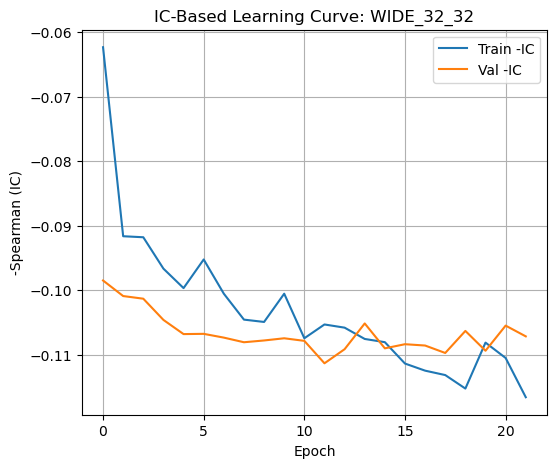

📊 Test IC: 0.0665 , p-value: 0.0


C:\Users\26954\AppData\Local\Temp\ipykernel_25644\1422460871.py:3: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

c:\Users\26954\anaconda3\lib\site-packages\_plotly_utils\basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



Information Coefficient (Spearman rho): 0.06648440843605977
P-value: 1.1119068790609618e-43
NN_hedge sharpe: 1.01470280895191, max_drawdown: -0.23834723258807666, annual return: 0.15945123108920728
NN_long sharpe: 0.27876500737289595, max_drawdown: -0.316182042560528, annual return: 0.0539089664582163
NN_short sharpe: 0.4310909283142316, max_drawdown: -0.5544556602803205, annual return: 0.10554226463099091

🚀 Running experiment: WIDE_64_64, hidden=(64, 64), alpha=0.0001, lr=0.001, batch=1024
⛔ Early stopped at epoch 17


📊 Test IC: 0.064 , p-value: 0.0


C:\Users\26954\AppData\Local\Temp\ipykernel_25644\1422460871.py:3: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

c:\Users\26954\anaconda3\lib\site-packages\_plotly_utils\basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



Information Coefficient (Spearman rho): 0.06398973701194534
P-value: 1.3816609055238373e-40
NN_hedge sharpe: 1.267570869802951, max_drawdown: -0.16864793148739507, annual return: 0.18520612780908932
NN_long sharpe: 0.33127285635426296, max_drawdown: -0.2945402868449445, annual return: 0.06144561633555333
NN_short sharpe: 0.5199730546999773, max_drawdown: -0.46671530871733474, annual return: 0.1237605114735357

🚀 Running experiment: DEEP_64_64_32, hidden=(64, 64, 32), alpha=0.0001, lr=0.001, batch=1024
⛔ Early stopped at epoch 20


📊 Test IC: 0.0635 , p-value: 0.0


C:\Users\26954\AppData\Local\Temp\ipykernel_25644\1422460871.py:3: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

c:\Users\26954\anaconda3\lib\site-packages\_plotly_utils\basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



Information Coefficient (Spearman rho): 0.0635317770918185
P-value: 4.961573675545371e-40
NN_hedge sharpe: 1.3459961944421055, max_drawdown: -0.15035192155674726, annual return: 0.1932876638801136
NN_long sharpe: 0.3492412984099736, max_drawdown: -0.2866109653106693, annual return: 0.06840041060475345
NN_short sharpe: 0.5365208361864516, max_drawdown: -0.4400115785924643, annual return: 0.12488725327536035

🚀 Running experiment: SHALLOW_32, hidden=(32,), alpha=0.0001, lr=0.001, batch=1024
⛔ Early stopped at epoch 34


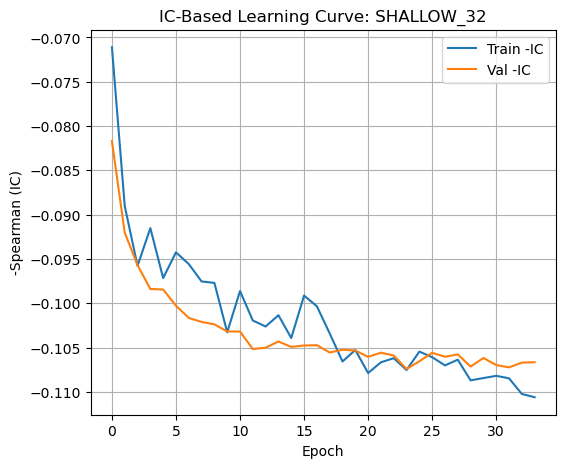

📊 Test IC: 0.0608 , p-value: 0.0


C:\Users\26954\AppData\Local\Temp\ipykernel_25644\1422460871.py:3: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

c:\Users\26954\anaconda3\lib\site-packages\_plotly_utils\basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



Information Coefficient (Spearman rho): 0.06080867042881581
P-value: 8.221764719219653e-37
NN_hedge sharpe: 1.0653578146745017, max_drawdown: -0.18956071016841072, annual return: 0.1650808396906883
NN_long sharpe: 0.27736017959434794, max_drawdown: -0.29872591540299165, annual return: 0.05062832410660158
NN_short sharpe: 0.477392805702757, max_drawdown: -0.5427379270414031, annual return: 0.11445251558408667

🚀 Running experiment: REG_WEAK, hidden=(32, 32), alpha=1e-05, lr=0.001, batch=1024
⛔ Early stopped at epoch 22


📊 Test IC: 0.0673 , p-value: 0.0


C:\Users\26954\AppData\Local\Temp\ipykernel_25644\1422460871.py:3: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

c:\Users\26954\anaconda3\lib\site-packages\_plotly_utils\basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



Information Coefficient (Spearman rho): 0.06729315691609167
P-value: 1.0412583937380395e-44
NN_hedge sharpe: 0.9938265408028153, max_drawdown: -0.2589079991000088, annual return: 0.15974483906491502
NN_long sharpe: 0.2778171480724323, max_drawdown: -0.31401956598166203, annual return: 0.053839394132557936
NN_short sharpe: 0.4357964403399726, max_drawdown: -0.5564704843238311, annual return: 0.10590544493235698

🚀 Running experiment: REG_STRONG, hidden=(32, 32), alpha=0.001, lr=0.001, batch=1024
⛔ Early stopped at epoch 22


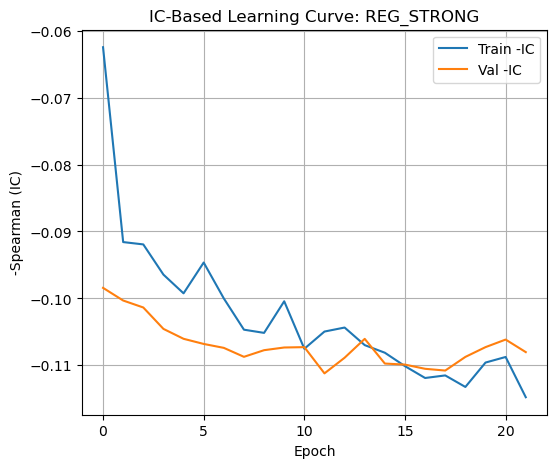

📊 Test IC: 0.0683 , p-value: 0.0


C:\Users\26954\AppData\Local\Temp\ipykernel_25644\1422460871.py:3: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

c:\Users\26954\anaconda3\lib\site-packages\_plotly_utils\basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



Information Coefficient (Spearman rho): 0.0683406938850704
P-value: 4.644121743674802e-46
NN_hedge sharpe: 1.06938647151082, max_drawdown: -0.23335223444791348, annual return: 0.16770181230234957
NN_long sharpe: 0.3388920252147186, max_drawdown: -0.30764973412067753, annual return: 0.0635430954799546
NN_short sharpe: 0.4314323893872168, max_drawdown: -0.5604735244421747, annual return: 0.10415871682239494

🚀 Running experiment: LR_FAST, hidden=(32, 32), alpha=0.0001, lr=0.005, batch=1024
⛔ Early stopped at epoch 18


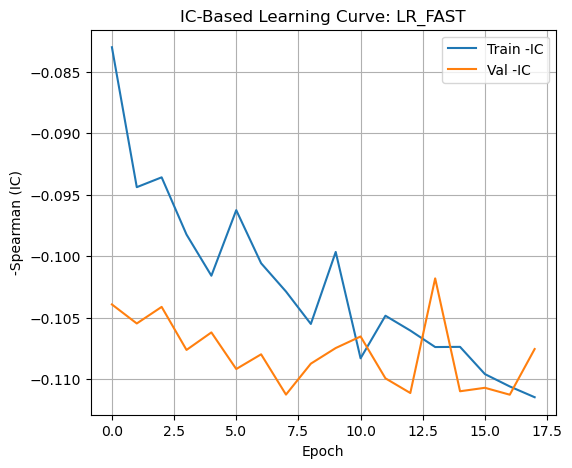

📊 Test IC: 0.0643 , p-value: 0.0


C:\Users\26954\AppData\Local\Temp\ipykernel_25644\1422460871.py:3: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

c:\Users\26954\anaconda3\lib\site-packages\_plotly_utils\basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



Information Coefficient (Spearman rho): 0.06429402851314739
P-value: 5.878788066895075e-41
NN_hedge sharpe: 1.0966747356602435, max_drawdown: -0.18438705227708793, annual return: 0.1671101917128392
NN_long sharpe: 0.27612579213693633, max_drawdown: -0.29902754627898537, annual return: 0.05294754694168885
NN_short sharpe: 0.46778985467402756, max_drawdown: -0.5389968674429004, annual return: 0.1141626447711504

🚀 Running experiment: LR_SLOW, hidden=(32, 32), alpha=0.0001, lr=0.0001, batch=1024


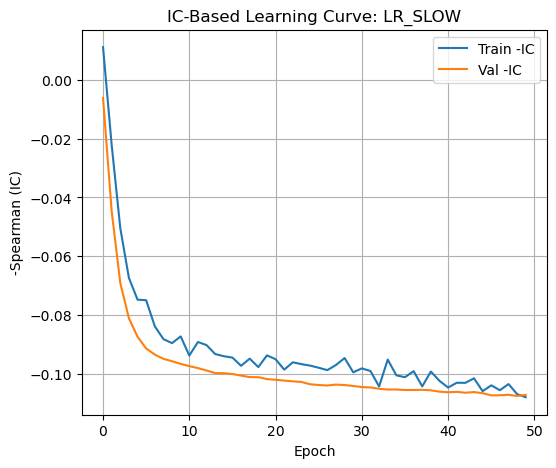

📊 Test IC: 0.0657 , p-value: 0.0


C:\Users\26954\AppData\Local\Temp\ipykernel_25644\1422460871.py:3: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

c:\Users\26954\anaconda3\lib\site-packages\_plotly_utils\basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



Information Coefficient (Spearman rho): 0.06574992838687174
P-value: 9.318961367257884e-43
NN_hedge sharpe: 1.1767920028803251, max_drawdown: -0.22598890289038032, annual return: 0.1756332557312489
NN_long sharpe: 0.3524721025572222, max_drawdown: -0.30294257501806776, annual return: 0.06540544904024048
NN_short sharpe: 0.45718438674333634, max_drawdown: -0.5187245043794375, annual return: 0.1102278066910086

🚀 Running experiment: BATCH_4096, hidden=(32, 32), alpha=0.0001, lr=0.001, batch=4096
⛔ Early stopped at epoch 35


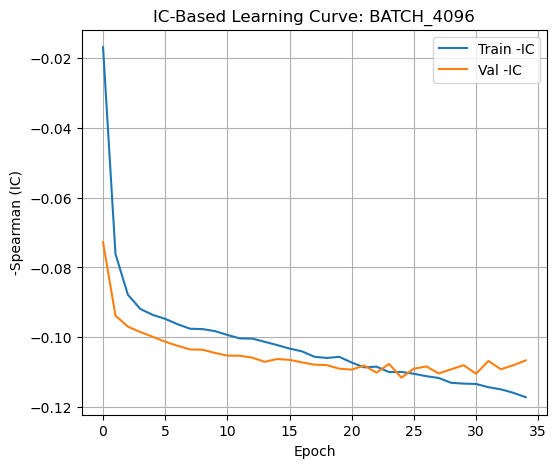

📊 Test IC: 0.0629 , p-value: 0.0


C:\Users\26954\AppData\Local\Temp\ipykernel_25644\1422460871.py:3: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

c:\Users\26954\anaconda3\lib\site-packages\_plotly_utils\basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



Information Coefficient (Spearman rho): 0.06294679538145957
P-value: 2.5064110989909478e-39
NN_hedge sharpe: 1.1914743880816017, max_drawdown: -0.17360835461607832, annual return: 0.17301670730683172
NN_long sharpe: 0.32635465851047585, max_drawdown: -0.29595842049074506, annual return: 0.06305140220745396
NN_short sharpe: 0.46590115025752643, max_drawdown: -0.530467147517015, annual return: 0.10996530509937796

🚀 Running experiment: BATCH_512, hidden=(32, 32), alpha=0.0001, lr=0.001, batch=512
⛔ Early stopped at epoch 19


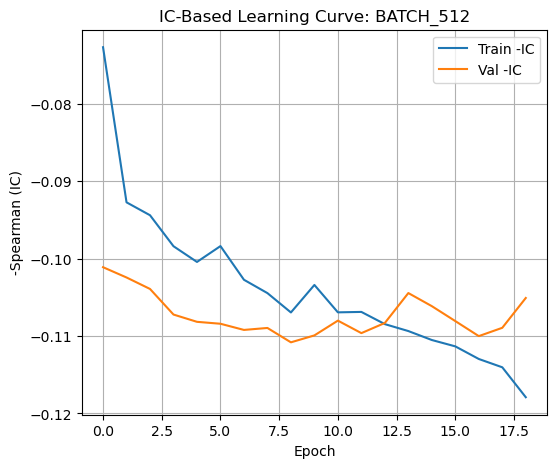

📊 Test IC: 0.0647 , p-value: 0.0


C:\Users\26954\AppData\Local\Temp\ipykernel_25644\1422460871.py:3: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

c:\Users\26954\anaconda3\lib\site-packages\_plotly_utils\basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



Information Coefficient (Spearman rho): 0.06467317003118768
P-value: 2.0157188524905818e-41
NN_hedge sharpe: 0.9514023712237496, max_drawdown: -0.27358706587574994, annual return: 0.15189925296274565
NN_long sharpe: 0.2611753381235473, max_drawdown: -0.31805916506929244, annual return: 0.04971112788915785
NN_short sharpe: 0.4178638080104733, max_drawdown: -0.5782753757713367, annual return: 0.10218812507358774

🚀 Running experiment: EXPRESSIVE_LOWREG, hidden=(64, 32), alpha=1e-05, lr=0.001, batch=512
⛔ Early stopped at epoch 19


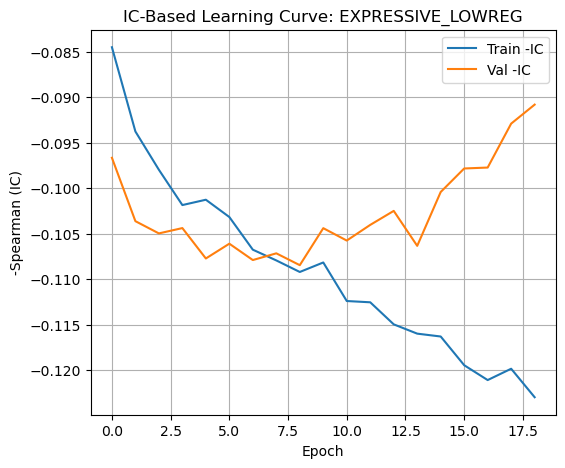

📊 Test IC: 0.0602 , p-value: 0.0


C:\Users\26954\AppData\Local\Temp\ipykernel_25644\1422460871.py:3: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

c:\Users\26954\anaconda3\lib\site-packages\_plotly_utils\basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



Information Coefficient (Spearman rho): 0.060175675144029016
P-value: 4.397428703246681e-36
NN_hedge sharpe: 1.4606042073327148, max_drawdown: -0.16182357178067885, annual return: 0.19427014051989128
NN_long sharpe: 0.31992564216488667, max_drawdown: -0.31394621475965784, annual return: 0.062465273439645155
NN_short sharpe: 0.5773176647021402, max_drawdown: -0.4572631012957534, annual return: 0.13180486708024616

🚀 Running experiment: WIDE_STRONGREG_BIGBATCH, hidden=(128,), alpha=0.001, lr=0.001, batch=2048
⛔ Early stopped at epoch 30


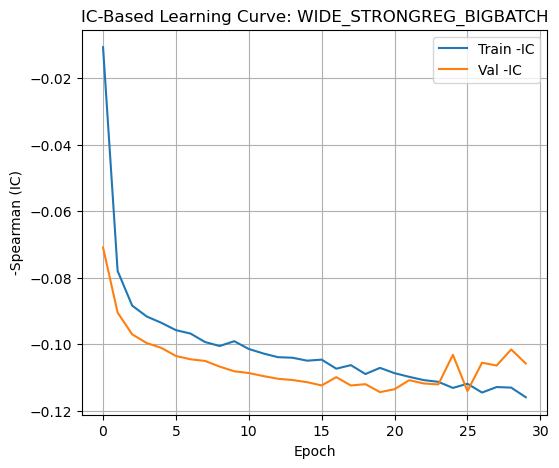

📊 Test IC: 0.0615 , p-value: 0.0


C:\Users\26954\AppData\Local\Temp\ipykernel_25644\1422460871.py:3: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

c:\Users\26954\anaconda3\lib\site-packages\_plotly_utils\basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



Information Coefficient (Spearman rho): 0.061547408007183176
P-value: 1.1362879214850809e-37
NN_hedge sharpe: 1.2111106199192703, max_drawdown: -0.23917306632742905, annual return: 0.19349764360661403
NN_long sharpe: 0.3542540684444591, max_drawdown: -0.29445523049615935, annual return: 0.06568289564494846
NN_short sharpe: 0.5419706444787792, max_drawdown: -0.5069317966419887, annual return: 0.1278147479616653


In [41]:
# === 执行扩展实验组 ===
for name, (arch, alpha, lr, batch) in new_architectures.items():
    run_experiment(name, hidden_layers=arch, alpha=alpha, lr=lr, batch_size=batch)

In [42]:
nn_results_df

name          arch    alpha       lr batch       ic  \
0                WIDE_32_32      (32, 32) 0.000100 0.001000  1024 0.066484   
1                WIDE_64_64      (64, 64) 0.000100 0.001000  1024 0.063990   
2             DEEP_64_64_32  (64, 64, 32) 0.000100 0.001000  1024 0.063532   
3                SHALLOW_32         (32,) 0.000100 0.001000  1024 0.060809   
4                  REG_WEAK      (32, 32) 0.000010 0.001000  1024 0.067293   
5                REG_STRONG      (32, 32) 0.001000 0.001000  1024 0.068341   
6                   LR_FAST      (32, 32) 0.000100 0.005000  1024 0.064294   
7                   LR_SLOW      (32, 32) 0.000100 0.000100  1024 0.065750   
8                BATCH_4096      (32, 32) 0.000100 0.001000  4096 0.062947   
9                 BATCH_512      (32, 32) 0.000100 0.001000   512 0.064673   
10        EXPRESSIVE_LOWREG      (64, 32) 0.000010 0.001000   512 0.060176   
11  WIDE_STRONGREG_BIGBATCH        (128,) 0.001000 0.001000  2048 0.061547   

       pval NN_hedge_sharpe NN_hedge_max_dd NN_hedge_returns  \
0  0.000000        1.014703       -0.238347         0.159451   
1  0.000000        1.267571       -0.168648         0.185206   
2  0.000000        1.345996       -0.150352         0.193288   
3  0.000000        1.065358       -0.189561         0.165081   
4  0.000000        0.993827       -0.258908         0.159745   
5  0.000000        1.069386       -0.233352         0.167702   
6  0.000000        1.096675       -0.184387         0.167110   
7  0.000000        1.176792       -0.225989         0.175633   
8  0.000000        1.191474       -0.173608         0.173017   
9  0.000000        0.951402       -0.273587         0.151899   
10 0.000000        1.460604       -0.161824         0.194270   
11 0.000000        1.211111       -0.239173         0.193498   

   NN_hedge_cumulative_return NN_long_sharpe NN_long_max_dd NN_long_returns  \
0                    1.953134       0.278765      -0.316182        0.053909   
1                    2.575655       0.331273      -0.294540        0.061446   
2                    2.795846       0.349241      -0.286611        0.068400   
3                    2.042525       0.277360      -0.298726        0.050628   
4                    1.930470       0.277817      -0.314020        0.053839   
5                    2.141393       0.338892      -0.307650        0.063543   
6                    2.113172       0.276126      -0.299028        0.052948   
7                    2.296016       0.352472      -0.302943        0.065405   
8                    2.317599       0.326355      -0.295958        0.063051   
9                    1.695416       0.261175      -0.318059        0.049711   
10                   2.888161       0.319926      -0.313946        0.062465   
11                   2.769991       0.354254      -0.294455        0.065683   

   NN_long_cumulative_return NN_short_sharpe NN_short_max_dd NN_short_returns  \
0                   0.352115        0.431091       -0.554456         0.105542   
1                   0.442869        0.519973       -0.466715         0.123761   
2                   0.504676        0.536521       -0.440012         0.124887   
3                   0.335654        0.477393       -0.542738         0.114453   
4                   0.350165        0.435796       -0.556470         0.105905   
5                   0.465875        0.431432       -0.560474         0.104159   
6                   0.338974        0.467790       -0.538997         0.114163   
7                   0.482076        0.457184       -0.518725         0.110228   
8                   0.445005        0.465901       -0.530467         0.109965   
9                   0.311785        0.417864       -0.578275         0.102188   
10                  0.439173        0.577318       -0.457263         0.131805   
11                  0.490493        0.541971       -0.506932         0.127815   

   NN_short_cumulative_return  
0                    0.673238  
1                    0.924240

In [43]:
nn_results_df.to_csv('nn_results_df.csv',index=False)

- 名称	亮点
- EXPRESSIVE_LOWREG	综合表现最强，收益高、回撤低、三策略都很稳
- DEEP_64_64_32	深层结构下的稳健收益者，适合高表达场景
- REG_STRONG	IC 最佳 + 回撤小，代表泛化能力强的模型

In [44]:
# === 构建 EXPRESSIVE_LOWREG 模型并训练 ===
set_seed(42)

model = SimpleNN(input_dim=X_train.shape[1], hidden_layers=(64, 32))
criterion = SpearmanApproxLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)

for epoch in range(30):
    model.train()
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()

model.eval()

# === 定义 Permutation Importance 计算函数 ===
def permutation_importance(model, X, y, metric_fn, n_repeats=3):
    base_score = metric_fn(model(X), y)
    importances = []
    for i in range(X.shape[1]):
        scores = []
        for _ in range(n_repeats):
            X_permuted = X.clone()
            X_permuted[:, i] = X_permuted[torch.randperm(X.shape[0]), i]
            score = metric_fn(model(X_permuted), y)
            scores.append(base_score - score)
        importances.append(np.mean(scores))
    return np.array(importances)

# === 使用 IC 作为评估指标 ===
from scipy.stats import spearmanr

def ic_metric(y_pred, y_true):
    ic, _ = spearmanr(y_pred.detach().numpy().flatten(), y_true.detach().numpy().flatten())
    return ic

# === 计算特征重要性 ===
importances = permutation_importance(model, X_test_tensor, y_test_tensor, ic_metric)
feature_importance_df = pd.DataFrame({
    'feature': X_test.columns,
    'importance': importances
}).sort_values(by='importance', ascending=False)

# === 输出前 20 个最重要的特征 ===
print("\n📊 Top 20 Important Features (by Permutation IC Drop):")
print(feature_importance_df.head(20))


📊 Top 20 Important Features (by Permutation IC Drop):
                              feature  importance
4                           amount_21    0.010033
3                      buffett_zscore    0.009094
0                              tpi_21    0.007882
6           std_unexpected_net_profit    0.007535
5                    idios_vol_ff3_21    0.006289
2  std_unexpected_net_profit_using_ar    0.002434
8                   aqr_profitability   -0.000153
9             sell_exp_to_revenue_ttm   -0.002284
1       gross_profit_to_asset_yoy_chg   -0.002500
7                                mcap   -0.004704


In [45]:
new_architectures_2 = {
    # ✅ 基准组：推荐保留用于对比
    'WIDE_32_32':    ((32, 32), 1e-4, 0.001, 1024),

    # 🔹【隐藏层】结构变宽/变深/变浅
    'WIDE_64_64':    ((64, 64), 1e-4, 0.001, 1024),
    'DEEP_64_64_32': ((64, 64, 32), 1e-4, 0.001, 1024),
    'SHALLOW_32':    ((32,), 1e-4, 0.001, 1024),

    # 🔹【正则化】变大和变小
    'REG_WEAK':      ((32, 32), 1e-5, 0.001, 1024),
    'REG_STRONG':    ((32, 32), 1e-3, 0.001, 1024),

    # 🔹【学习率】更快/更慢
    'LR_FAST':       ((32, 32), 1e-4, 0.005, 1024),
    'LR_SLOW':       ((32, 32), 1e-4, 0.0001, 1024),

    # 🔹【Batch Size】更大/更小
    'BATCH_4096':    ((32, 32), 1e-4, 0.001, 4096),
    'BATCH_512':     ((32, 32), 1e-4, 0.001, 2024),
    'BATCH_512':     ((32, 32), 1e-4, 0.001, 512),

    # 🔹【组合试验】更强表达 + 更小正则 + 更小batch
    'EXPRESSIVE_LOWREG': ((64, 32), 1e-5, 0.001, 512),

    # 🔹【组合试验】宽浅 + 强正则 + 更大 batch
    'WIDE_STRONGREG_BIGBATCH': ((128,), 1e-3, 0.001, 2048),
}